# Révision

Dans les cours et TPs précédents, vous avez étudié des algorithmes de base du traitement d'images en couleurs et en niveaux de gris. Notamment, nous avons vu les notions suivantes :

- Représentation d'images en niveaux de gris et RGB sous forme de tableaux de deux et de trois dimensions
- Histogrammes d'images en niveaux de gris
- Convolution et _padding_
- Floutage et détection de bords en utilisant des convolutions (filtres linéaires) et la médiane (filtre d'ordre / non-linéaire)
- Seuillage binaire
- Recadrage dynamique et égalisation d'histogramme

Dans les TPs précédents, vous avez implémenté certains de ces algorithmes à la main afin de mieux comprendre leur fonctionnement et complexité. Dans ce TP de révision et dans l'évaluation qui suit, vous pouvez utiliser vos propres implémentations de chacune de ces fonctions, ou bien utiliser les fonctions fournies par les librairies **OpenCV** et **Numpy**. 

### Import des modules et fonctions de base

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Operateurs implémentés dans les TPs 1, 2 et 3

def moyenneur(img, taille_filtre):
    return cv.blur(img,(taille_filtre,taille_filtre),borderType=cv.BORDER_CONSTANT)

def sobel(img):
    Gx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
    Gy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)

    moduleGradient = np.sqrt(Gx**2 + Gy**2)
    gradientNormalise = 255*(moduleGradient - np.min(moduleGradient))/(np.max(moduleGradient) - np.min(moduleGradient))

    return gradientNormalise

def histogramme(img):
    hist = np.zeros(256)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i][j]] += 1
    return hist 
    
def histogrammeCumule(img):
    hist = histogramme(img)
    for k in range(1,256):
        hist[k] += hist[k-1]
    return hist  

def normalisation(img):
    resultat = np.round(255*((img-np.min(img))/(np.max(img)-np.min(img))))
    return resultat.astype('uint8')
    
def egalisation(img):
    min = np.min(img)
    max = np.max(img)
    hist_cum = histogrammeCumule(img)
    hist_cum_normalise = hist_cum/(np.max(hist_cum))*255
    img_egalisee = img
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_egalisee[i,j] = hist_cum_normalise[img_egalisee[i,j]]
    return img_egalisee

### Rappel des fonctions de base

```image = cv.imread("test.png")``` $\rightarrow$ charge une image RVB sous forme d'un tableau à trois dimensions (bleu, vert et rouge)

Notez que ```image[:,:,0]``` correspond à la composante Bleu, ```image[:,:,1]``` correspond à la composante Verte, et ```image[:,:,2]``` correspond à la composante Rouge.

```image_gris = cv.imread("test.png",0)``` $\rightarrow$ charge "test.png" comme une image en niveau de gris (matrice/tableau à deux dimensions)

```image = image[:,:,::-1]``` $\rightarrow$ inverse la première et la troisième composante de l'image (après cette opération, ```image[:,:,0]``` correspond à la composante Rouge et ```image[:,:,2]``` correspond à la composante Bleu)

```tab = np.zeros(shape=(10,10,3))```  $\rightarrow$ crée un tableau de zéros de dimension $10 \times 10 \times 3$

```_,imgBlancNoir = cv.threshold(image_gris,seuil,255,cv.THRESH_BINARY)``` $\rightarrow$ calcule le seuillage binaire de l'image ```image_gris``` : les pixels ayant un niveau de gris supérieur ou égal à ```seuil``` sont attribués à 255 (blanc) dans l'image résultante

```image_median = cv.medianBlur(image_gris, 5)``` $\rightarrow$ applique un filtre médian de taille 5x5 sur l'image d'entrée

```plt.imshow(image)``` $\rightarrow$ affiche une image en couleurs

```plt.imshow(image_gris, cmap="gray", vmin=0, vmax=255)``` $\rightarrow$ affiche "correctement" une image en niveau de gris

```hist = histogramme(image_gris)``` $\rightarrow$ calcule l'histogramme d'une image en niveau de gris sous forme d'un tableau de taille 256

```plt.plot(histogramme(img))``` $\rightarrow$ affiche l'histogramme d'une image en utilisant la fonction definie ci-dessus

Si plusieurs images/figures doivent être affichées dans une même cellule, ajoutez ```plt.show()``` après chaque ```plt.imshow(...)``` et chaque ```plt.plot(...)```

## 1 Seuillage d'images RVB et en niveau de gris, histogrammes et filtres

**Q1** Ouvre et affichez l'image en couleur _chat.png_.

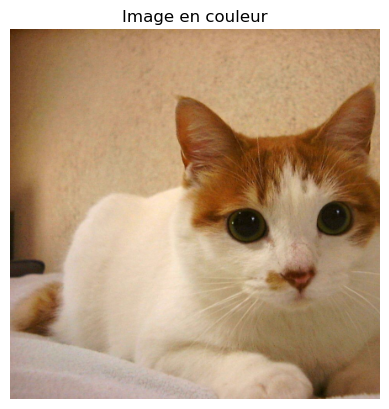

In [2]:
# Chargement de l'image en couleur (cv.imread charge en BGR)
img = cv.imread("chat.png")
# Conversion en RGB pour l'affichage avec matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img_rgb)
plt.title("Image en couleur")
plt.axis("off")
plt.show()

**Q2** Affichez les composantes R, G et B individuellement sous forme d'images en niveaux de gris.

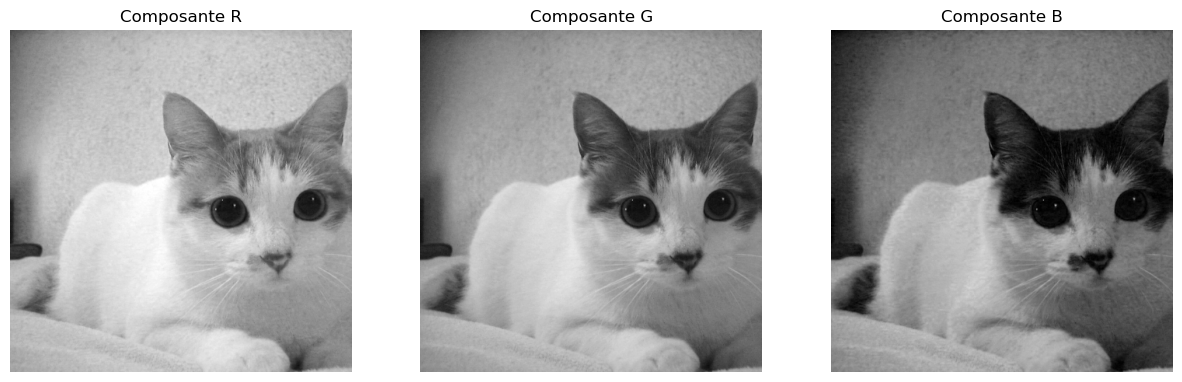

In [3]:
# Après conversion en RGB, les canaux sont dans l'ordre R, G, B
R = img_rgb[:,:,0]
G = img_rgb[:,:,1]
B = img_rgb[:,:,2]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(R, cmap="gray", vmin=0, vmax=255)
plt.title("Composante R")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(G, cmap="gray", vmin=0, vmax=255)
plt.title("Composante G")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(B, cmap="gray", vmin=0, vmax=255)
plt.title("Composante B")
plt.axis("off")
plt.show()


**Q3** En utilisant la formule ```I_gris = 0.299 ∗ R + 0.587 ∗ G + 0.114 ∗ B```, convertissez l'image RGB en une image en niveau de gris (vous pouvez le faire avec ou sans utiliser des boucles)

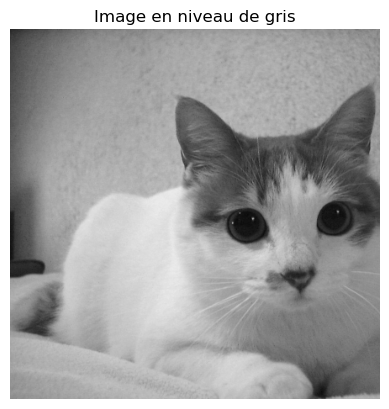

In [4]:
# Calcul du niveau de gris à partir des trois canaux
I_gris = 0.299 * R + 0.587 * G + 0.114 * B
# On convertit en entier non signé 8 bits
I_gris = I_gris.astype(np.uint8)

plt.figure()
plt.imshow(I_gris, cmap="gray", vmin=0, vmax=255)
plt.title("Image en niveau de gris")
plt.axis("off")
plt.show()


**Q4** Calculez l'histogramme de l'image en niveau de gris résultante. Que peut-on conclure en regardant seulement son histogramme ? Est-ce une image sombre ou bien lumineuse ? Que peut-on dire concernant son niveau de contraste ?

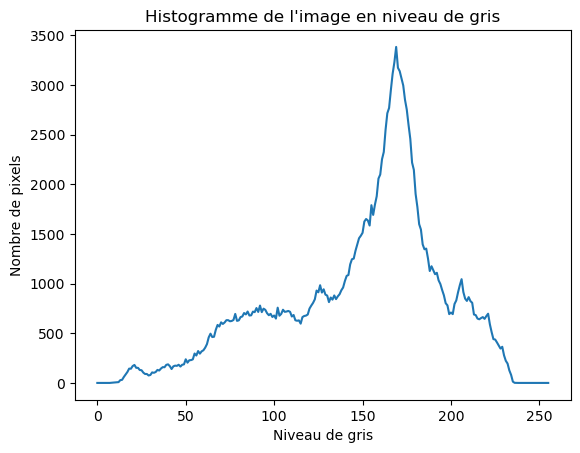

In [5]:
def histogramme(img):
    hist = np.zeros(256)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i][j]] += 1
    return hist 

# Calcul de l'histogramme
hist = histogramme(I_gris)

plt.figure()
plt.plot(hist)
plt.title("Histogramme de l'image en niveau de gris")
plt.xlabel("Niveau de gris")
plt.ylabel("Nombre de pixels")
plt.show()


**Q5** Créez une nouvelle image ```I_gris_2``` de même dimension que ```I_gris``` où la valeur de chaque pixel est remplacée par la moitié de sa valeur originale plus 100 (afin de bien afficher l'image résultante, utilisez ```plt.imshow(I_gris_2, cmap="gray", vmin=0, vmax=255)```). 

Que fait-il cette opération ? 

Comparez l'histogramme de cette nouvelle image avec celui de ```I_gris```.

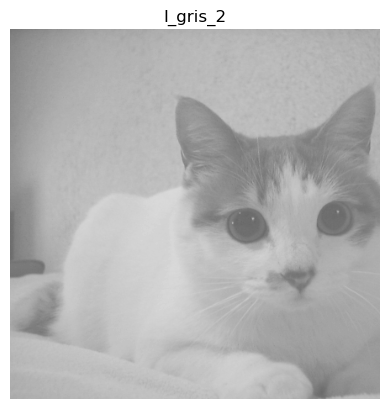

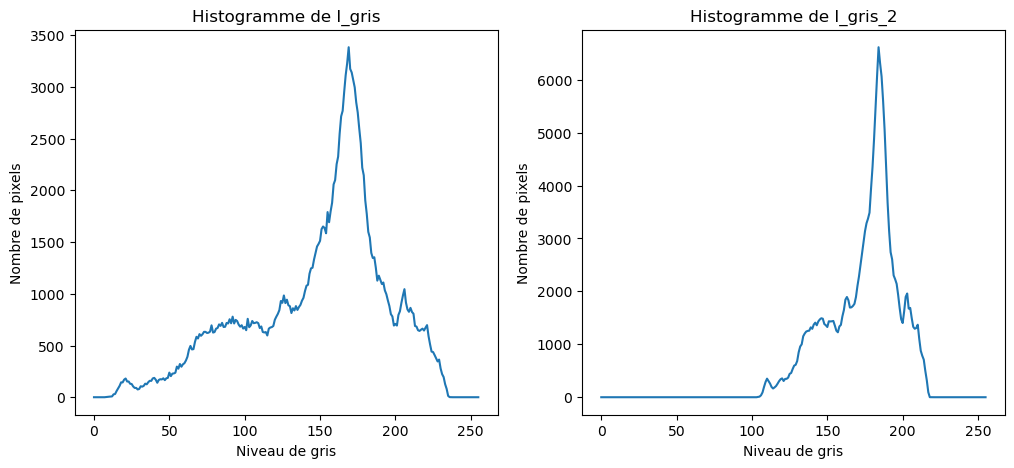

In [6]:
# Transformation : division par 2 puis ajout de 100
I_gris_2 = (I_gris / 2.0 + 100).astype(np.uint8)

plt.figure()
plt.imshow(I_gris_2, cmap="gray", vmin=0, vmax=255)
plt.title("I_gris_2")
plt.axis("off")
plt.show()

# Comparaison des histogrammes
hist_original = histogramme(I_gris)
hist_new = histogramme(I_gris_2)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist_original)
plt.title("Histogramme de I_gris")
plt.xlabel("Niveau de gris")
plt.ylabel("Nombre de pixels")

plt.subplot(1,2,2)
plt.plot(hist_new)
plt.title("Histogramme de I_gris_2")
plt.xlabel("Niveau de gris")
plt.ylabel("Nombre de pixels")
plt.show()


**Q6** Comment peut-on rétablir le niveau de contraste de l'image ```I_gris_2``` ? Testez les deux méthodes vues en cours.

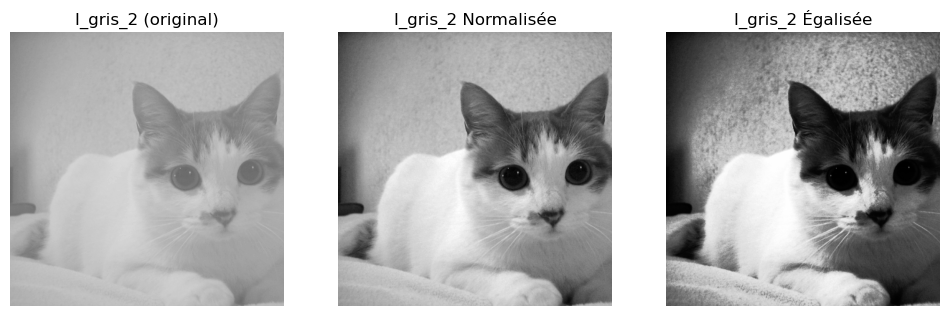

In [7]:
def normalisation(img):
    resultat = np.round(255*((img - np.min(img))/(np.max(img) - np.min(img))))
    return resultat.astype('uint8')

def egalisation(img):
    # On commence par calculer l'histogramme cumulé
    hist = histogramme(img)
    hist_cum = np.copy(hist)
    for k in range(1, 256):
        hist_cum[k] += hist_cum[k-1]
    # Normalisation du cumul pour obtenir une transformation linéaire
    hist_cum_normalise = hist_cum / hist_cum[-1] * 255
    img_egalisee = np.copy(img)
    # Remplacement de chaque pixel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_egalisee[i, j] = hist_cum_normalise[img_egalisee[i, j]]
    return img_egalisee

# Méthode 1 : Normalisation
I_gris_2_norm = normalisation(I_gris_2)

# Méthode 2 : Égalisation
I_gris_2_eq = egalisation(I_gris_2)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(I_gris_2, cmap="gray", vmin=0, vmax=255)
plt.title("I_gris_2 (original)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(I_gris_2_norm, cmap="gray", vmin=0, vmax=255)
plt.title("I_gris_2 Normalisée")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(I_gris_2_eq, cmap="gray", vmin=0, vmax=255)
plt.title("I_gris_2 Égalisée")
plt.axis("off")

plt.show()


**Q7** À partir de l'image en niveau de gris, segmentez les yeux du chat en produisant une image binaire où seulement les pixels appartenant aux yeux sont blancs, et tous les autres sont en noir (notez que le résultat ne sera pas forcément parfait). 

Si la région devant être segmentée est plus sombre que le reste de l'image, vous pouvez utiliser son inverse, c.-à-d., ```255 - I_gris```.

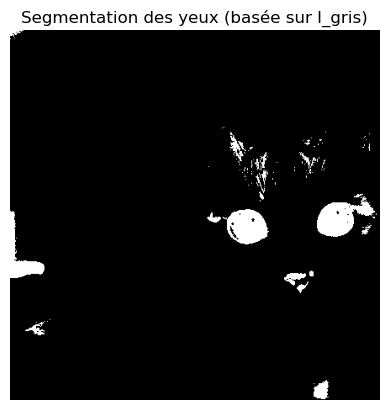

In [8]:
# Inversion de l'image pour que les zones sombres deviennent claires
I_inv = 255 - I_gris

# Seuillage : on choisit ici une valeur seuil empirique (par exemple 200)
_, eyes = cv.threshold(I_inv, 200, 255, cv.THRESH_BINARY)

plt.figure()
plt.imshow(eyes, cmap="gray", vmin=0, vmax=255)
plt.title("Segmentation des yeux (basée sur I_gris)")
plt.axis("off")
plt.show()


**Q8** Maintenant, faites le même, mais à partir des composantes rouge, verte et bleue de l'image originale (notez que le résultat ne sera pas forcément parfait).

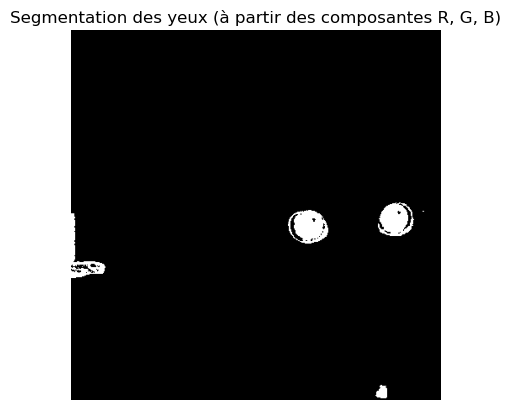

In [9]:
# Inversion de chaque canal
R_inv = 255 - R
G_inv = 255 - G
B_inv = 255 - B

# Application d'un seuillage sur chacun (seuil choisi empiriquement, ici 200)
_, R_thresh = cv.threshold(R_inv, 200, 255, cv.THRESH_BINARY)
_, G_thresh = cv.threshold(G_inv, 200, 255, cv.THRESH_BINARY)
_, B_thresh = cv.threshold(B_inv, 200, 255, cv.THRESH_BINARY)

# Combinaison des trois masques (on peut utiliser un AND pour ne garder que les zones où les trois canaux sont "élevés")
eyes_color = cv.bitwise_and(R_thresh, cv.bitwise_and(G_thresh, B_thresh))

plt.figure()
plt.imshow(eyes_color, cmap="gray", vmin=0, vmax=255)
plt.title("Segmentation des yeux (à partir des composantes R, G, B)")
plt.axis("off")
plt.show()


**Q9** En suivant le même principe de la question précédente, segmentez les cerises dans l'image ```cerises.png```.

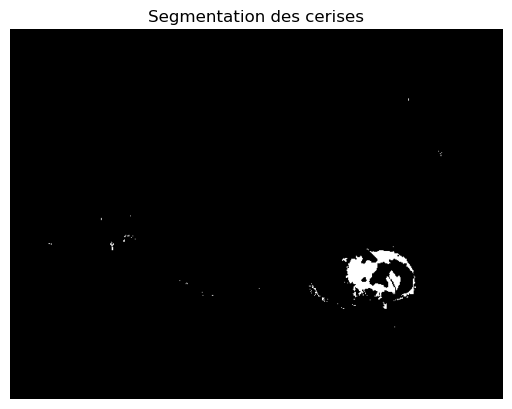

In [10]:
# Chargement de l'image des cerises et conversion en RGB
cerises = cv.imread("cerises.png")
cerises_rgb = cv.cvtColor(cerises, cv.COLOR_BGR2RGB)

# Extraction des canaux
R_c = cerises_rgb[:,:,0]
G_c = cerises_rgb[:,:,1]
B_c = cerises_rgb[:,:,2]

# On définit un masque : les pixels dont la composante rouge est élevée tandis que les composantes verte et bleue sont faibles
mask_cerises = np.logical_and(R_c > 150, np.logical_and(G_c < 100, B_c < 100))
mask_cerises = (mask_cerises * 255).astype(np.uint8)

plt.figure()
plt.imshow(mask_cerises, cmap="gray", vmin=0, vmax=255)
plt.title("Segmentation des cerises")
plt.axis("off")
plt.show()


**Q10** À partir de l'image bruitée ```renard_bruit.png```, trouvez les opérations permettant d'obtenir des contours binaires comme affiché ci-dessous.

![Image](renard_bruit.png) ![Image](renard_contours.png)

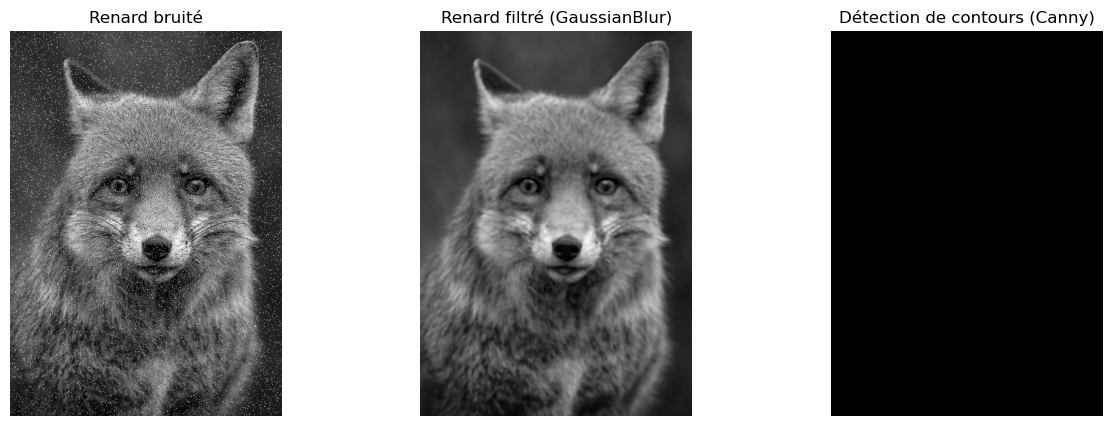

In [112]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Chargement de l'image en niveaux de gris
renard = cv.imread("renard_bruit.png", 0)
if renard is None:
    raise ValueError("L'image 'renard_bruit.png' n'a pas été trouvée.")

# Réduction du bruit : application d'un flou Gaussien (vous pouvez aussi essayer medianBlur)
blurred = cv.medianBlur(renard, 5)

# Affichage des images pour comparaison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(renard, cmap="gray", vmin=0, vmax=255)
plt.title("Renard bruité")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(blurred, cmap="gray", vmin=0, vmax=255)
plt.title("Renard filtré (GaussianBlur)")
plt.axis("off")

# using the canny edge detector
# edges = cv.Canny(blurred, 30, 120)

# using the sobel operator
# edges = sobel(blurred)

# using the laplacian operator
# edges = cv.Laplacian(blurred, cv.CV_64F)

# using the scharr operator
# edges = cv.Scharr(blurred, cv.CV_64F, 1, 0)

# using the prewitt operator
# kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

# using the previus
# cerises_rgb = cv.cvtColor(cerises, cv.COLOR_BGR2RGB)

# # Extraction des canaux
# R_c = cerises_rgb[:,:,0]
# G_c = cerises_rgb[:,:,1]
# B_c = cerises_rgb[:,:,2]

# # On définit un masque : les pixels dont la composante rouge est élevée tandis que les composantes verte et bleue sont faibles
# mask_cerises = np.logical_and(R_c > 150, np.logical_and(G_c < 100, B_c < 100))
# mask_cerises = (mask_cerises * 255).astype(np.uint8)
renard_rgb = cv.cvtColor(renard, cv.COLOR_GRAY2RGB)

# Extraction des canaux
R_r = renard_rgb[:,:,0]
G_r = renard_rgb[:,:,1]
B_r = renard_rgb[:,:,2]

# On définit un masque : les pixels dont la composante rouge est élevée tandis que les composantes verte et bleue sont faibles
mask_renard = np.logical_and(R_r > 150, np.logical_and(G_r < 100, B_r < 100))
mask_renard = (mask_renard * 255).astype(np.uint8)


plt.subplot(1, 3, 3)
plt.imshow(mask_renard, cmap="gray", vmin=0, vmax=255)
plt.title("Détection de contours (Canny)")
plt.axis("off")

plt.show()
